<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=200></center>

<h6><center>Introduction to Machine Learning</center></h6>

<h1>
<hr style=" border:none; height:3px;">
<center>Tutorial 3: Supervised learning</center>
<hr style=" border:none; height:3px;">
</h1>


# Introduction

In this tutorial we first use some synthetic data to understand how Support Vector Machines (SVMs) work, the effect of their hyperparameters and what the kernel trick is all about.

We also use a real dataset to train a classifier that recognizes handwritten digits.

<div class="alert alert-block alert-info">

For the most part, the Python code is already written for you. You're invited to **read the code and the comments** to learn how to practice machine learning with *Scikit-learn*. Your instructor will also explain the code.

</div>



# Setup

We import the modules that are commonly used in combination with Scikit-learn.

<div class="alert alert-block alert-warning">
In order to run this notebook, you'll need to install <b>Python 3.5 or later</b>, as well as <b>Scikit-learn 0.20 or later</b>.
</div>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Numpy arrays are used to store training and test data.
import numpy as np

# Pandas is used to manipulate tabular data.
import pandas as pd

# Matplotlib is used to plot graphs.
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
# Style options for plots.
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998).
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Convenience function to create display a progress bar.
# Source : https://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console
def print_progress_bar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()
 
# Saves a figure to a file
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join("./figs", fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Experimenting with SVM

In this section we play with the hyperparameters of Support Vector Machines (SVM) and learn their effect. 
We first define the function *plot_svc_decision_boundary* that plots the decision boundary learned by a SVM.

In [2]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    ''' Plots the decision boundary of a support vector machine.
    
    Parameters
    ----------
        svn_clf : sklearn.svm.SVC
            The classifier.
        xmin: float
            The minimum value on the x-axis.
        xmax: float
            The maximum value of the x-axis.
    '''
    
    # Get the parameters learned from the training data.
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    # Get the margin and the two lines where the support vectors are.
    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

We generate a synthetic dataset with the function <a href="https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html" target="_blank">*make_classification*</a>. 

<div class="alert alert-block alert-success">

**Question 1.** In the following cell, play with the parameters *class_sep* and *flip_y* to understand their effect on the generated dataset.

</div>


(-6.523434071009125, 6.388693526431721, -6.585908560176217, 6.591239462318816)

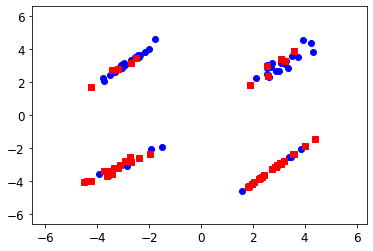

In [3]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=100, 
    n_features=2,
    n_informative=2,
    n_redundant=0,
    class_sep=3,
    flip_y=0.35, 
    random_state=42)

plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "rs")
plt.axis([X[:, 0].min() - 2, X[:, 0].max() + 2, X[:, 1].min() - 2, X[:, 1].max() + 2])

## Hard and soft margin

Now let's generate the following dataset. 

(-6.585908560176217, 6.591239462318816, -6.523434071009125, 6.388693526431721)

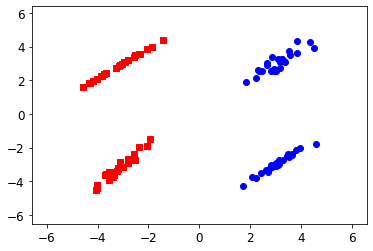

In [4]:
X, y = make_classification(
    n_samples=100, 
    n_features=2,
    n_informative=2,
    n_redundant=0,
    class_sep=3,
    flip_y=0, 
    random_state=42)

plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "rs")
plt.axis([X[:, 0].min() - 2, X[:, 0].max() + 2, X[:, 1].min() - 2, X[:, 1].max() + 2])

In the following cell, we train a linear SVM on the generated dataset. 

<div class="alert alert-block alert-success">

**Question 2.** Play with the hyperparameter $C$ of the SVM by setting the following values $10^{-3}$, $10^{-2}$, $10^{-1}$, $10^{0}$, $10^{1}$, $10^{2}$, $10^{3}$.
How does the decision boundary change?

</div>

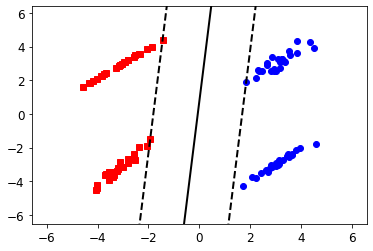

In [5]:
from sklearn.svm import SVC


svm = SVC(kernel="linear", C=10**(3), random_state=42)
svm.fit(X, y)

plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "rs")
plt.axis([X[:, 0].min() - 2, X[:, 0].max() + 2, X[:, 1].min() - 2, X[:, 1].max() + 2])

plot_svc_decision_boundary(svm, X[:, 0].min() - 2, X[:, 0].max() + 2)

Now we generate the following dataset, where some of the red instances are *outliers*, in the sense that they have values for the features that make them "look like" blue instances.

(-7.585908560176217, 7.591239462318816, -7.684162118584036, 7.388693526431721)

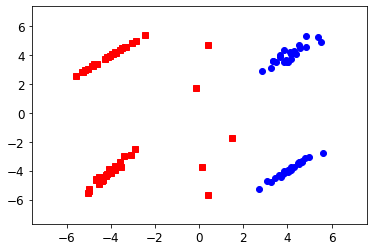

In [6]:
import random

X, y = make_classification(
    n_samples=100, 
    n_features=2,
    n_informative=2,
    n_redundant=0,
    class_sep=4,
    flip_y=0, 
    random_state=42)

X_outliers = [[random.uniform(-1, 2), random.uniform(-6, 6), ] for _ in range(5)]
for i in range(len(X_outliers)):
    X = np.vstack((X, X_outliers[i]))
    y = np.hstack((y, [0]))
    


plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "rs")
plt.axis([X[:, 0].min() - 2, X[:, 0].max() + 2, X[:, 1].min() - 2, X[:, 1].max() + 2])

<div class="alert alert-block alert-success">

**Question 3.** Play again with the hyperparameter $C$ and look at how the decision boundary changes. What is the implication for the prediction model?

</div>

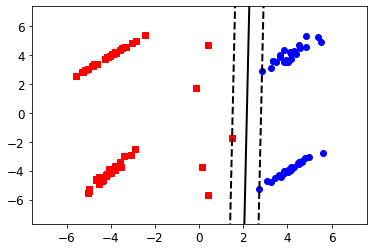

In [7]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

svm = SVC(kernel="linear", C=10**(3), random_state=42) #Cgrand: overfitting / Cpetit: underfitting

plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "rs")
plt.axis([X[:, 0].min() - 2, X[:, 0].max() + 2, X[:, 1].min() - 2, X[:, 1].max() + 2])

svm.fit(X, y)
plot_svc_decision_boundary(svm, X[:, 0].min() - 2, X[:, 0].max() + 2)


<div class="alert alert-block alert-success">

**Question 4.** Based on the experiences of the previous question, what would you do on the values of $C$ if you realized that your prediction model is overfitting? What if your model is underfitting?

</div>

## Nonlinear SVM classification

SVMs are defined for linearly separable classification problems; however, many real datasets are not linearly separable. One approach to handling these cases is to add more features. One example is to add polynomial features.

The following cell generates a dataset where each instance is described by only one feature $x_1$. Clearly, the instances are not linearly separable.

(-4.5, 4.5, -0.2, 0.2)

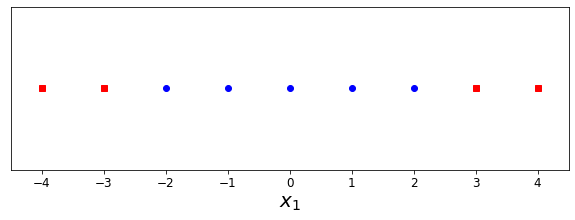

In [8]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 3))
plt.plot(X1D[:, 0][y==0], np.zeros(4), "rs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "bo")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])


<div class="alert alert-block alert-success">

**Question 5.** Propose a transformation of the given dataset to a 2-dimensional space by defining a new feature $x_2$ obtained as a polynomial of $x_1$. Implement the transformation and train a linear SVM on the transformed dataset.

</div>

In [ ]:
# Write here the code
X2D= X1D ** 2
svm = SVC(kernel="linear", C=10**(3), random_state=42)
svm.fit(X, y)

plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "rs")
plt.axis([X[:, 0].min() - 2, X[:, 0].max() + 2, X[:, 1].min() - 2, X[:, 1].max() + 2])

plot_svc_decision_boundary(svm, X[:, 0].min() - 2, X[:, 0].max() + 2)

Making up polynomial features is easy when we have a toy dataset such as the one in the previous question. Consider the following dataset. It is generated by using the Scikit-learn function <a href="https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html" target="_blank">make_moons</a>. 

Although the resulting dataset is still very simple, it would be more difficult than before to create new features especially because that would require the visualization of  the transformed dataset in three or more dimensions.

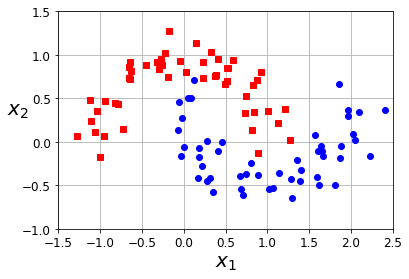

In [26]:
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "rs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

Scikit-learn comes to our rescue by providing the class <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html" target="_blank">*PolynomialFeatures*</a> that allows for the creation of new polynomial features with no intervention from us. The only thing that we need to do is to specify the degree of the polynomial.


<div class="alert alert-block alert-success">

**Question 6.** In the code below, play with the degree of the polynomial. What happens if you increase its value? What happens if you decrease it?

</div>

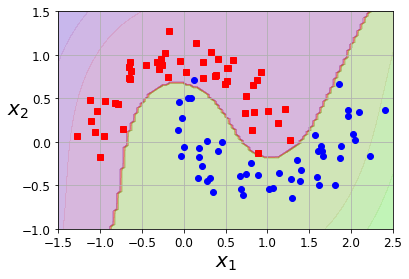

In [27]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import PolynomialFeatures


polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)), #degré= nbr de features ajoutées, mais plus de degrés , il overfit et prend plus de temps, mais non on le fait pour appliquer un classifier lineair sur des données non lineaires
        ("svm_clf", SVC(C=10, kernel="linear"))
    ])

polynomial_svm_clf.fit(X, y)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

<div class="alert alert-block alert-success">

**Question 7.** Would you consider the solution of adding new features to the dataset acceptable? What is the main problem here? 

</div>

### The kernel trick

The **kernel trick** allows us to obtain the exact same result we were trying to get by adding more features without the need of adding new features. 

Suppose that we have a non-linearly separable dataset where each instance $\mathbf{x}$ is defined by two features $(x_1, x_2)$.  Suppose that we have a function $\phi$ that transforms the dataset into one in three dimensions, where it is linearly separable. The function $\phi$ is defined as follows:

$$
\begin{align}
    \phi(\mathbf{x}) &= 
          \begin{pmatrix}
           x_1^2 \\           
           \sqrt{2} x_1 x_2 \\
           x_2^2
          \end{pmatrix}
  \end{align}
$$

Consider now two instances $\mathbf{a} = (a_1, a_2)$ and $\mathbf{b} = (b_1, b_2)$ and what happens when we apply the dot product of the transformed vectors:

$$
\begin{align}
    \phi(\mathbf{a})^T \phi(\mathbf{b})  &= 
          \begin{pmatrix}
           a_1^2 \\           
           \sqrt{2} a_1 a_2 \\
           a_2^2
          \end{pmatrix}^T
          \times
          \begin{pmatrix}
           b_1^2 \\           
           \sqrt{2} b_1 b_2 \\
           b_2^2
          \end{pmatrix}
          = a_1^2 b_1^2 + 2 a_1 b_1 a_2 b_2 + a_2^2 b_2^2 = (a_1 b_1 + a_2 b_2)^2 = (\mathbf{a}^T \mathbf{b})^2
  \end{align}
$$

In practice, the dot product of the transformed vectors can be computed by using the values of the features in the original space! Therefore, there is no need to make any transformation at all! This is extremely important, because when solving the constrained optimization problem of the SVM, we can plug the dot product $\phi(\mathbf{a})^T \phi(\mathbf{b})$ in the dual formulation, which results in training the SVM in a higher dimensional space, without computing the transformation explicitly. The transformation $\phi$ is a **kernel function**, one that can compute the dot product $\phi(\mathbf{a})^T \phi(\mathbf{b})$ based only on the original vectors. 

A common kernel that we're going to use in the following cell is the **polynomial kernel**, defined as follows:

$$
K(\mathbf{a}, \mathbf{b}) = (\gamma \mathbf{a}^T \mathbf{b} + r)^d
$$

This kernel is defined by three parameters:

* $\gamma$: is a scaling factor. Low values of $\gamma$ will erase the effect of a large degree. This parameter is usually not considered (scikit-learn sets its value to 1/num_features).

* $d$: is the degree of the polynomial. In Scikit-learn, this parameter is called $degree$.

* $r$: is a free parameter trading off the influence of higher-order versus lower-order terms in the polynomial. Scikit-learn sets its default value to 0. Some references set its value to 1. In Scikit-learn this parameter is called $coef0$.

<div class="alert alert-block alert-success">

**Question 8.** Looking at the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html" target="_blank">documentation of SVC</a> in Scikit-Learn, write the code the trains a SVM with polynomial kernel for the training set $(X, y)$. Play with the parameters $degree$ and $coef0$.

</div>

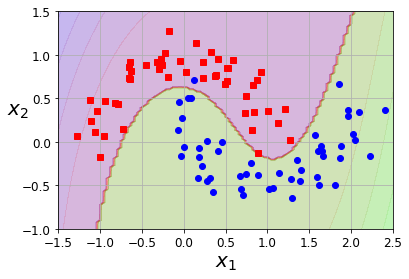

In [34]:
#Write here the code
model = SVC(C=10, kernel="poly", degree = 3, coef0=100) # je crois donnne de l'importance aux features de petit degré
model.fit(X, y)
plot_predictions(model, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

Adding polynomial features is not the only way to transform a non-linearly separable dataset into a linearly separable one. Another technique consists in adding features computed using a *similarity function*, which measures how much each instance resembles a particular reference point, also termed a *landmark* $l$.

Let's consider again the dataset with only one feature.

(-4.5, 4.5, -0.2, 0.2)

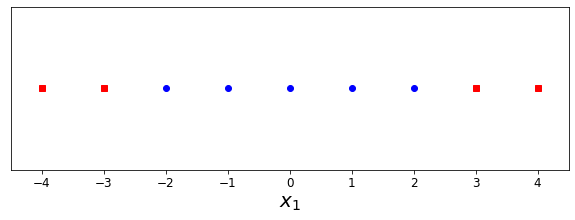

In [35]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 3))
plt.plot(X1D[:, 0][y==0], np.zeros(4), "rs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "bo")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])

Suppose that we want to transform the dataset so as it is described by two features. We define two landmarks; the first $\mathbf{l_1}$ is defined at $x_1 = -2$ and the other $\mathbf{l_2}$ is defined at $x_1 = 1$. 

each instance will be described by two new features $x_2$ and $x_3$, where the value of $x_2$ is the similarity of the instance to the first landmark $\mathbf{l_1}$ and the value of $x_3$ is the similarity of the instance to the second landmark $\mathbf{l_2}$.

More precisely, let's define the following similarity measure, called the Gaussian **Radial Basis Function** (RBF):

$$\phi_\gamma(\mathbf{x}, \mathbf{l}) = exp(-\gamma || \mathbf{x} - \mathbf{l} ||^2)$$

Let $\gamma = 0.3$; if we take the instance at $x_1=-1$, its distance from the first landmark is 1, while its distance from the second landmark is 2. Therefore, its new features will be $exp(-0.3 \times 1^2) \approx 0.74$ and 
$exp(-0.3 \times 2^2) \approx 0.30$. This can be iterated for every instance, which will give the new dataset that is now linearly separable.

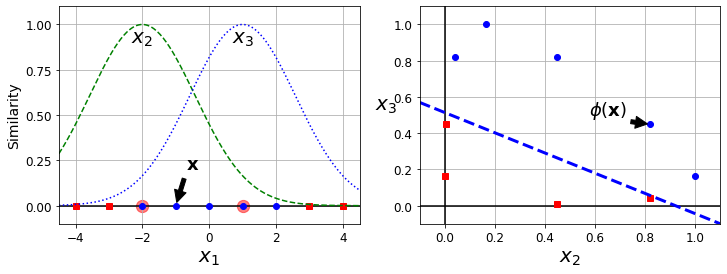

In [42]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.2 #gamma grand donc overfit

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10.5, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "rs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "bo")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "rs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "bo")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "b--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)  

<div class="alert alert-block alert-success">

**Question 9.** Rerun the previous cell by using different values for $\gamma$. What happens when you decrease the value of $\gamma$? What happens when you increase it?

</div>

As in the case of the polynomial features, the kernel trick comes to our rescue here too.
In fact, we can use the **Gaussian RBF Kernel** to obtain the same result without transforming the dataset.
The RBF kernel is defined as follows:

$$K(\mathbf{x}, \mathbf{y}) = exp(-\gamma || \mathbf{x} - \mathbf{y} ||^2)$$

<div class="alert alert-block alert-success">

**Question 10.** Run the following cell that trains a SVM with RBF kernel with different values of $\gamma$ and $C$. Comment on the effect of both parameters on the decision boundary.

</div>

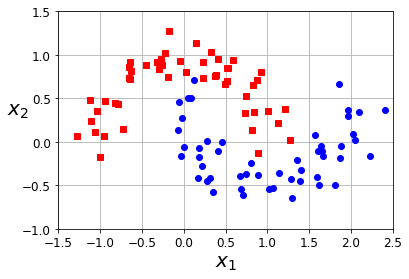

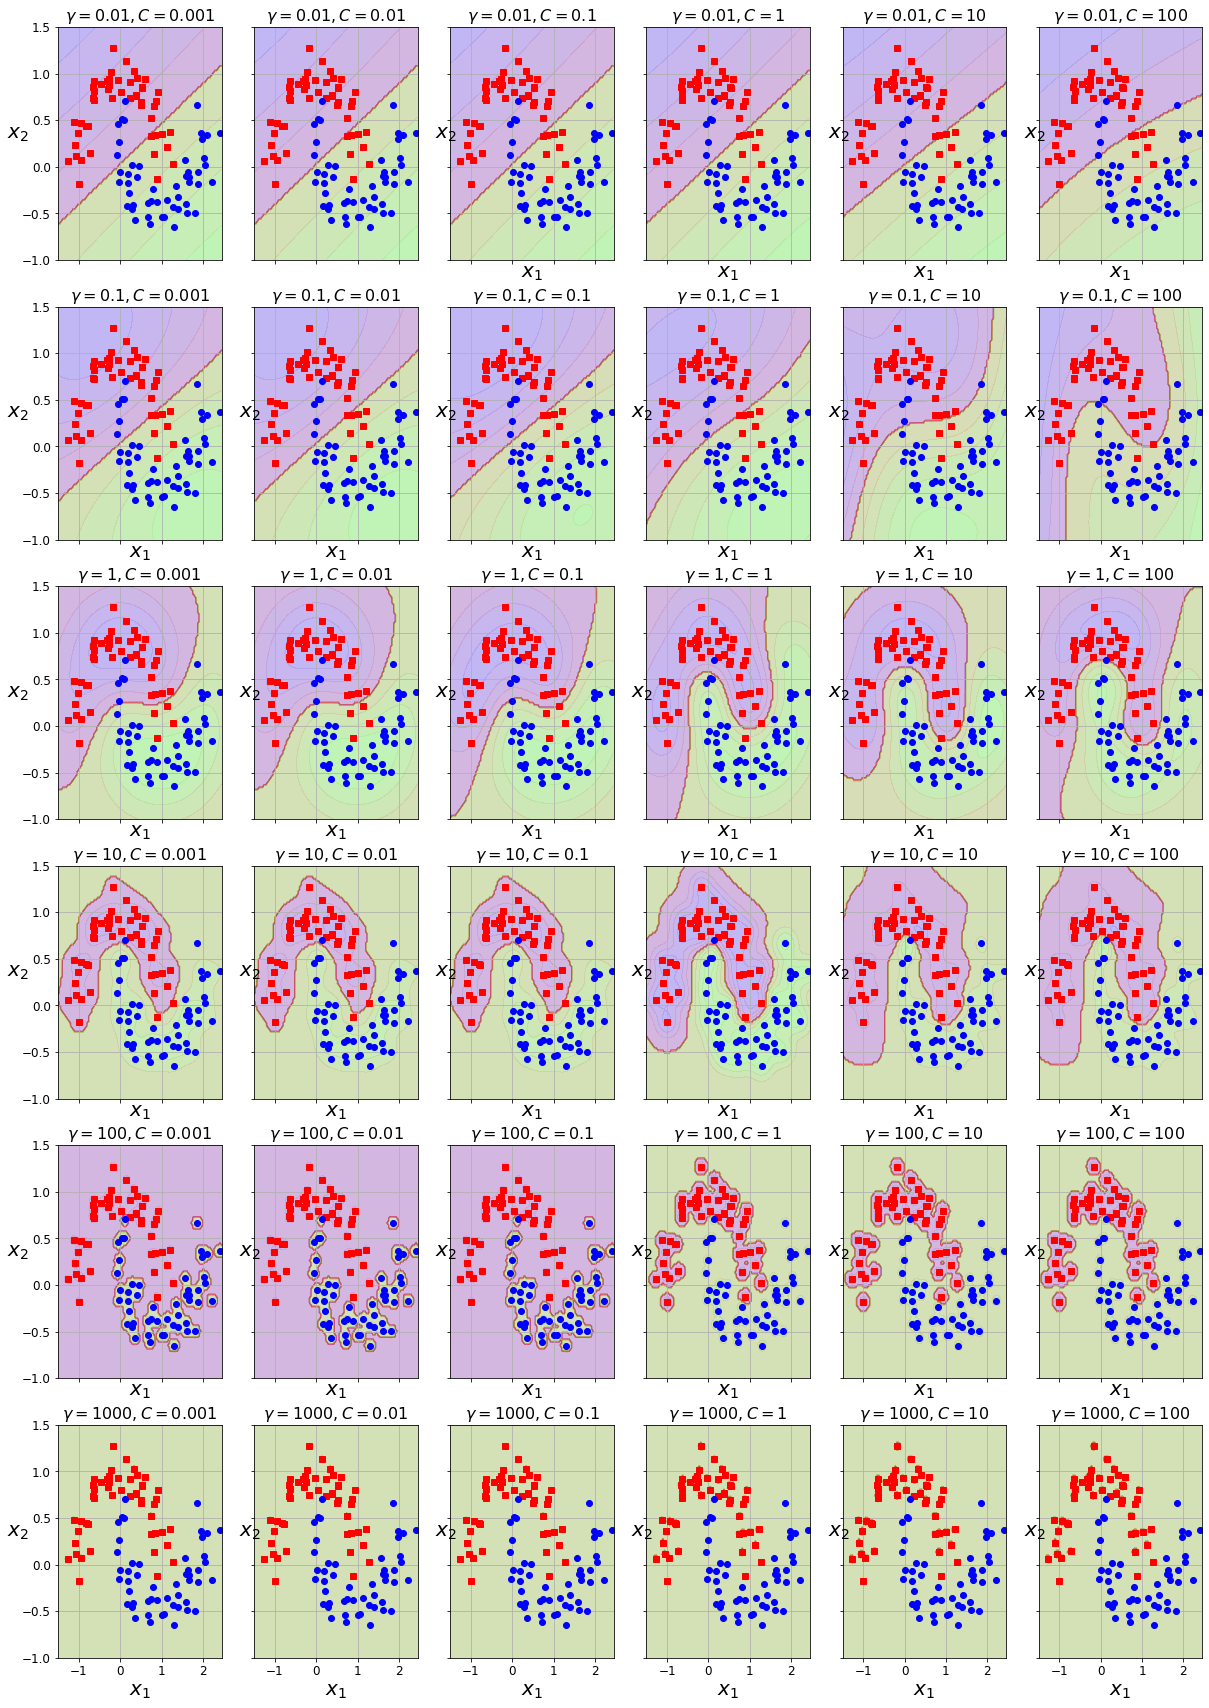

In [43]:
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

hyperparams = [(10**i, 10**j) for i in range(-2, 4) for j in range(-3, 3)]


svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(20.5, 30), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 6, i % 6])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")



# Experimenting with real data

## Dataset MNIST and SVM

We're going to consider the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau.

First of all, let's download the dataset and split it into a training and test set. The training set is composed of the first 60000 instances.

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]



<div class="alert alert-block alert-info">

Many training algorithms are sensitive to the order of the training instances, so it's generally good practice to shuffle them first. However, the dataset is already shuffled, so we do not need to do it.

</div>



By running the following cell, we get the number of training instances, the number of features  and the classes.

In [ ]:
print("Number of training instances {}".format(np.ma.size(X_train, axis=0)))
print("Number of test instances {}".format(np.ma.size(X_test, axis=0)))
print("Number of features {}".format(np.ma.size(X_train, axis=1)))
print("Classes {}".format(np.unique(y_train)))

As you can see, there are 9 classes. It is not a binary classification problem.

<div class="alert alert-block alert-success">

**Question 11.** How can we train a SVM on a multi-class classification problem?

</div>

<div class="alert alert-block alert-info">
So far, we have only used the class SVC from the Scikit-learn. However, in order to train a linear classifier, we can also use the class <a href="https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html" target="_blank">LinearSVC</a>. 

Its implementation is based on the library *liblinear* instead of *libsvc* and is optimized for the linear case (it does not support the kernel trick). Its computational time scales linearly with the number of instances in the dataset. 

</div>

Let's try a linear SVM to begin with. LinearSVC implements the strategy One-vs-All automatically.

<div class="alert alert-block alert-warning">

**The following might take a little while.**

</div>

In [ ]:
from sklearn.svm import LinearSVC
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train, y_train)

Let's evaluate the f1-score on the training set itself.

In [ ]:
from sklearn.metrics import f1_score

y_pred = lin_clf.predict(X_train)
f1_score(y_train, y_pred, average='micro')

A f1-score of 0.895 is far from optimal on this dataset.


<div class="alert alert-block alert-success">

**Question 12.** What can you do to improve the results? Is there anything that we plainly ignored up until now when training a SVM?

</div>

In [ ]:
#Write here the code

Train again a linear SVM.

<div class="alert alert-block alert-warning">

The following might take a little while.

</div>

In [ ]:
#Write here the code


We now try again to predict the training instances:

In [ ]:
#Write here the code


Let's use a RBF kernel. Use only 10000 training instances in order to make the training phase faster.

In [ ]:
#Write here the code

We test again on the training instances.

In [ ]:
# Write here the code

Discuss the result that you obtained.

Now, we use only 1000 instances in order to run cross-validation and try to find the best hyperparameters $C$ and $\gamma$.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train_scaled[:1000], y_train[:1000])


rnd_search_cv.best_score_

The result might seem a bit deceiving, given that before we had more than a f1 score of 0.945. However, we trained on only 1/60 of the training set. Let's train the best classifier that we found with cross-validation on 10000 instances.

In [ ]:
rnd_search_cv.best_estimator_.fit(X_train_scaled[:10000], y_train[:10000])

Let's use the model to make predictions on the test set.

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
f1_score(y_test, y_pred, average='micro')